# Changelog

## Version 23

* Final hyperparameter tuning
* Use 3, 5 & 10 StratifiedKFold

## Version 21

* Tuning LightGBM parameter from version 20 result
    * lambda pair : [0.0, 0.0], [0.001, 0.01], [0.01, 0.1], [0.01, 1.0], [1.0, 0.01]
* Try different boosting_type
* Change formula for weighted ensemble mean
* Use 3 & 5 StratifiedKFold

## Version 20

* Tuning LightGBM parameter from version 18 result
* Stop using validation data

## Version 18

* Tuning LightGBM parameter from version 16 result
    * num_leaves : 63
    * min_data_in_leaf : 20, 50
    * bagging_fraction : **no diff**
    * feature_fraction : 0.9, 1.0
    * max_bin : 16, 102, 255
    * min_data_per_group : 1
* Use validation data to reduce overfit

## Version 16

* Tuning LightGBM parameter from version 15 result
    * boosting_type : gbdt
    * n_estimators : 100
    * LR : 0.01
    * num_leaves : 31, 63
    * min_data_in_leaf : 20, 50

## Version 15

* Make submission for all mode
* Fix dump `df_model`
* Remove `age` from category feature

## Version 13

* Tuning LightGBM parameter
* Add additional preprocessing
* Add EDA

## Version 10

* Add additional preprocessing

## Version 9

* Use StratifiedKFold 3, 5, 10
* Combine parameter from verison 4 & 5
* Use mean and mode to predict data

## Version 5

* Use MCC score
* Visualize LightGBM tree
* Use different processed dataset
* Specify categorical feature
* Tweak parameter

## Version 4

* Attempt fix overfit
* Tweak class weight

## Version 2

* Fix wrong row
* Lower `max_bin` 255 -> 64
* Increase `num_iterations` 5000 -> 10000

## Version 1

* Initial Code

# Library

In [1]:
import os
import random
import platform
import itertools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import lightgbm as lgbm
import scipy

In [2]:
!pip freeze > requirements.txt

In [3]:
print('Python version:', platform.python_version())
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Matplotlib version:', matplotlib.__version__)
print('Seaborn version:', sns.__version__)
print('Scikit-Learn version:', sklearn.__version__)
print('LightGBM version:', lgbm.__version__)
print('Scipy version:', scipy.__version__)

Python version: 3.7.6
Numpy version: 1.18.5
Pandas version: 1.0.3
Matplotlib version: 3.2.1
Seaborn version: 0.10.0
Scikit-Learn version: 0.23.1
LightGBM version: 2.3.1
Scipy version: 1.4.1


In [4]:
SEED = 42

os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [5]:
pd.set_option('display.width', None)
pd.set_option('display.max_column', None)

# Dataset

In [6]:
df_train = pd.read_parquet('/kaggle/input/shopee-marketing-data/train_processed.parquet')
df_train

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,open_flag,attr_1,attr_2,attr_3,age,domain
0,4,2019-07-16 00:00:00+08:00,44,19.0,6.0,18.0,0,2,4,12,43,99,0,5,10,0,1.0,1.0,2.0,47.0,0.0
1,4,2019-07-16 00:00:00+08:00,44,9.0,4.0,8.0,2,9,17,18,48,90,1,1,4,1,1.0,1.0,2.0,25.0,3.0
2,6,2019-07-16 00:00:00+08:00,49,14.0,5.0,5.0,0,4,12,24,69,119,5,19,27,0,NaN,1.0,0.0,NaN,2.0
3,1,2019-07-16 00:00:00+08:00,49,49.0,9.0,53.0,0,0,1,9,23,69,1,3,6,0,1.0,1.0,2.0,24.0,2.0
4,6,2019-07-16 00:00:00+08:00,49,227.0,6.0,221.0,0,0,0,2,5,5,0,0,0,0,NaN,1.0,0.0,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73534,6,2019-09-02 00:00:00+08:00,39,24.0,36.0,279.0,0,1,1,0,0,0,0,0,0,0,1.0,1.0,1.0,37.0,0.0
73535,2,2019-09-02 00:00:00+08:00,38,46.0,10.0,51.0,0,0,1,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
73536,2,2019-09-02 00:00:00+08:00,32,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,9.0
73537,2,2019-09-02 00:00:00+08:00,38,5.0,34.0,NaN,2,4,4,0,0,0,0,0,0,1,NaN,1.0,0.0,NaN,0.0


In [7]:
df_test = pd.read_parquet('/kaggle/input/shopee-marketing-data/test_processed.parquet')
df_test

,country_code,grass_date,subject_line_length,last_open_day,last_login_day,last_checkout_day,open_count_last_10_days,open_count_last_30_days,open_count_last_60_days,login_count_last_10_days,login_count_last_30_days,login_count_last_60_days,checkout_count_last_10_days,checkout_count_last_30_days,checkout_count_last_60_days,attr_1,attr_2,attr_3,age,domain
0,6,2019-09-03 00:00:00+08:00,35,27.0,2.0,13.0,2,3,4,10,34,134,0,6,18,NaN,1.0,0.0,NaN,0.0
1,6,2019-09-03 00:00:00+08:00,35,7.0,5.0,383.0,1,1,1,5,5,5,0,0,0,NaN,1.0,0.0,NaN,0.0
2,5,2019-09-03 00:00:00+08:00,25,34.0,1.0,3.0,0,0,0,13,19,38,2,2,2,1.0,1.0,2.0,33.0,0.0
3,1,2019-09-03 00:00:00+08:00,36,63.0,5.0,5.0,0,0,0,43,110,173,2,5,5,1.0,1.0,2.0,22.0,2.0
4,5,2019-09-03 00:00:00+08:00,23,6.0,5.0,54.0,0,0,0,4,12,39,0,0,2,NaN,1.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55965,6,2019-09-29 00:00:00+08:00,53,NaN,4.0,8.0,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,3.0
55966,6,2019-09-29 00:00:00+08:00,53,59.0,802.0,1207.0,0,0,1,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
55967,6,2019-09-29 00:00:00+08:00,43,NaN,7.0,NaN,0,0,0,0,0,0,0,0,0,NaN,1.0,0.0,NaN,0.0
55968,6,2019-09-29 00:00:00+08:00,43,5.0,5.0,6.0,2,5,14,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


# preprocessing

## 1. Timedate

In [8]:
df_train['day'] = pd.to_datetime(df_train['grass_date']).dt.dayofweek.astype('category')
df_test['day'] = pd.to_datetime(df_test['grass_date']).dt.dayofweek.astype('category')

In [9]:
del df_train['grass_date']
del df_test['grass_date']

## 2. Anomaly

In [10]:
def fix_age(age):
    if age < 18 or age >= 100:
        return np.nan
    else:
        return age
    
df_train['age'] = df_train['age'].apply(fix_age)
df_test['age'] = df_test['age'].apply(fix_age)

## 3. NaN

In [11]:
# # last_open_day
# df_train['last_open_day_nan'] = df_train['last_open_day'].isnull()
# df_train['last_open_day'] = df_train['last_open_day'].fillna(-1)

# df_test['last_open_day_nan'] = df_test['last_open_day'].isnull()
# df_test['last_open_day'] = df_test['last_open_day'].fillna(-1)

# # last_login_day
# df_train['last_login_day_nan'] = df_train['last_login_day'].isnull()
# df_train['last_login_day'] = df_train['last_login_day'].fillna(-1)

# df_test['last_login_day_nan'] = df_test['last_login_day'].isnull()
# df_test['last_login_day'] = df_test['last_login_day'].fillna(-1)

# # last_checkout_day
# df_train['last_checkout_day_nan'] = df_train['last_checkout_day'].isnull()
# df_train['last_checkout_day'] = df_train['last_checkout_day'].fillna(-1)

# df_test['last_checkout_day_nan'] = df_test['last_checkout_day'].isnull()
# df_test['last_checkout_day'] = df_test['last_checkout_day'].fillna(-1)

# # attr_1
# df_train['attr_1_nan'] = df_train['attr_1'].isnull()
# df_train['attr_1'] = df_train['attr_1'].fillna(-1)

# df_test['attr_1_nan'] = df_test['attr_1'].isnull()
# df_test['attr_1'] = df_test['attr_1'].fillna(-1)

# # attr_2
# df_train['attr_2_nan'] = df_train['attr_2'].isnull()
# df_train['attr_2'] = df_train['attr_2'].fillna(-1)

# df_test['attr_2_nan'] = df_test['attr_2'].isnull()
# df_test['attr_2'] = df_test['attr_2'].fillna(-1)

# # attr_3
# df_train['attr_3_nan'] = df_train['attr_3'].isnull()
# df_train['attr_3'] = df_train['attr_3'].fillna(-1)

# df_test['attr_3_nan'] = df_test['attr_3'].isnull()
# df_test['attr_3'] = df_test['attr_3'].fillna(-1)

# # age
# df_train['age_nan'] = df_train['age'].isnull()
# df_train['age'] = df_train['age'].fillna(-1)

# df_test['age_nan'] = df_test['age'].isnull()
# df_test['age'] = df_test['age'].fillna(-1)

In [12]:
# domain
# 1 -> 'other' domain from previous preprocessing
# df_train['domain_nan'] = df_train['domain'].isnull()
df_train['domain'] = df_train['domain'].fillna(1)

# df_test['domain_nan'] = df_test['domain'].isnull()
df_test['domain'] = df_test['domain'].fillna(1)

## 4. Misc

In [13]:
X = df_train.copy()
del X['open_flag']

X_test = df_test.copy()

y = df_train['open_flag'].to_numpy()

In [14]:
cat_feature = [
    'country_code','attr_1', 'attr_2', 'attr_3',
    'domain','day',
#     'last_open_day_nan', 'last_login_day_nan',
#     'last_checkout_day_nan', 'attr_1_nan', 'attr_2_nan',
#     'attr_3_nan', 'age_nan', 'domain_nan',
    
]
cat_feature_idx = [X.columns.get_loc(ct) for ct in cat_feature]
cat_feature_idx

[0, 14, 15, 16, 18, 19]

# Model

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef

K = [3, 5, 10]

In [16]:
param_dict = {
    'learning_rate': [0.0075, 0.01, 0.0125],
    'min_data_in_leaf': [20, 50],
    'max_bin': [16, 102, 255],
    'lambda': [
        # l1, l2
        [0.0, 0.0],
        [0.001, 0.01],
        [0.01, 0.1],
        [1.0, 0.01],
    ],
    'n_estimators': [100, 125, 150]
}
param_key = list(param_dict.keys())
param_item = list(param_dict.values())
param_item

[[0.0075, 0.01, 0.0125],
 [20, 50],
 [16, 102, 255],
 [[0.0, 0.0], [0.001, 0.01], [0.01, 0.1], [1.0, 0.01]],
 [100, 125, 150]]

In [17]:
param_list = list(itertools.product(*param_item))
param_list[:10]

[(0.0075, 20, 16, [0.0, 0.0], 100),
 (0.0075, 20, 16, [0.0, 0.0], 125),
 (0.0075, 20, 16, [0.0, 0.0], 150),
 (0.0075, 20, 16, [0.001, 0.01], 100),
 (0.0075, 20, 16, [0.001, 0.01], 125),
 (0.0075, 20, 16, [0.001, 0.01], 150),
 (0.0075, 20, 16, [0.01, 0.1], 100),
 (0.0075, 20, 16, [0.01, 0.1], 125),
 (0.0075, 20, 16, [0.01, 0.1], 150),
 (0.0075, 20, 16, [1.0, 0.01], 100)]

In [18]:
len(param_list)

216

In [19]:
df_model = pd.DataFrame(columns=[*param_key, *[f'model_{i}' for i in range(sum(K))], *[f'model_{i}_mcc' for i in range(sum(K))], 'average_mcc'])
df_model

,learning_rate,min_data_in_leaf,max_bin,lambda,n_estimators,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_0_mcc,model_1_mcc,model_2_mcc,model_3_mcc,model_4_mcc,model_5_mcc,model_6_mcc,model_7_mcc,model_8_mcc,model_9_mcc,model_10_mcc,model_11_mcc,model_12_mcc,model_13_mcc,model_14_mcc,model_15_mcc,model_16_mcc,model_17_mcc,average_mcc


In [20]:
skf_list = [StratifiedKFold(n_splits=k, shuffle=True, random_state=SEED) for k in K]

for param in param_list:
    ctr = 0
    model = []
    mcc_score = []
    for skf in skf_list:
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X.loc[train_idx], X.loc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model.append(
                lgbm.LGBMClassifier(
                    # fixed
                    is_unbalance=True,
                    seed=SEED,
                    extra_trees=True,

                    min_data_per_group=1,
                    boosting_type='goss',
                    num_leaves=63,
                    feature_fraction=0.9,
                    # variable
                    learning_rate=param[0],
                    min_data_in_leaf=param[1],
                    max_bin=param[2], 
                    lambda_l1=param[3][0],
                    lambda_l2=param[3][1],
                    n_estimators=param[4],
                )
            )
            model[ctr].fit(
                X_train, y_train,
                categorical_feature=cat_feature_idx
            )

            y_val_pred = model[ctr].predict(X_val)
            mcc_score.append(matthews_corrcoef(y_val, y_val_pred))

            ctr += 1
    df_model.loc[ df_model.shape[0] ] = [
        *param,
        *model,
        *mcc_score,
        sum(mcc_score) / len(mcc_score)
    ]

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 14, 15, 16, 18, 19]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


# Evaluate

In [21]:
df_model = df_model.sort_values(by=['average_mcc', 'learning_rate'], ascending=[False, True]).reset_index(drop=True)
df_model.loc[:1000].to_pickle('model.pkl')
!ls -lah

total 3.1G
drwxr-xr-x 2 root root 4.0K Aug  8 12:09 .
drwxr-xr-x 6 root root 4.0K Aug  8 10:19 ..
---------- 1 root root 308K Aug  8 12:09 __notebook__.ipynb
-rw-r--r-- 1 root root 3.1G Aug  8 12:11 model.pkl
-rw-r--r-- 1 root root  14K Aug  8 10:19 requirements.txt


In [22]:
pd.set_option('display.max_row', df_model.shape[0])

In [23]:
df_model

,learning_rate,min_data_in_leaf,max_bin,lambda,n_estimators,model_0,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,model_11,model_12,model_13,model_14,model_15,model_16,model_17,model_0_mcc,model_1_mcc,model_2_mcc,model_3_mcc,model_4_mcc,model_5_mcc,model_6_mcc,model_7_mcc,model_8_mcc,model_9_mcc,model_10_mcc,model_11_mcc,model_12_mcc,model_13_mcc,model_14_mcc,model_15_mcc,model_16_mcc,model_17_mcc,average_mcc
0,0.0075,50,16,"[0.0, 0.0]",125,"LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...",0.520467,0.518198,0.523221,0.522937,0.524918,0.523703,0.524762,0.515562,0.518992,0.531655,0.511165,0.534386,0.526562,0.522477,0.512125,0.536186,0.525021,0.509318,0.522314
1,0.0075,50,102,"[0.001, 0.01]",125,"LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...",0.517991,0.517272,0.524960,0.524647,0.524054,0.526645,0.525876,0.514853,0.516582,0.534776,0.507646,0.531646,0.524490,0.522455,0.516032,0.536150,0.522201,0.510380,0.522148
2,0.0075,20,16,"[0.0, 0.0]",125,"LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_tre...",0.519024,0.517475,0.522734,0.523282,0.525632,0.522826,0.523897,0.516957,0.517965,0.531999,0.508016,0.535424,0.525900,0.520401,0.511441,0.539939,0.523976,0.510355,0.522069
3,0.0075,20,16,"[0.001, 0.01]",125,"LGBMClassifier(boosting_type='goss', extra_tre...","LGBMClassifier(boosting_type='goss', extra_

In [24]:
pd.set_option('display.max_row', 10)

In [25]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, precision_score, matthews_corrcoef

def predict(X, mode='best_mean'):
    if mode == 'best_mode':
        y_preds = []
        for i in range(sum(K)):
            y_preds.append(df_model.loc[0, f'model_{i}'].predict(X))
        y_preds = np.array(y_preds)
        y_preds = scipy.stats.mode(y_preds)
        y_preds = y_preds[0]
        y_preds = y_preds.reshape(-1)
    elif mode == 'best_mean':
        y_preds = []
        for i in range(sum(K)):
            y_preds.append(df_model.loc[0, f'model_{i}'].predict_proba(X))
        y_preds = np.mean(np.array(y_preds), axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    elif mode == 'ensemble_mode':
        y_preds = []
        for i in df_model.index:
            for j in range(sum(K)):
                y_preds.append(df_model.loc[i, f'model_{j}'].predict(X))
        y_preds = np.array(y_preds)
        y_preds = scipy.stats.mode(y_preds)
        y_preds = y_preds[0]
        y_preds = y_preds.reshape(-1)
    elif mode == 'ensemble_mean':
        y_preds = []
        for i in df_model.index:
            for j in range(sum(K)):
                y_preds.append(df_model.loc[i, f'model_{j}'].predict_proba(X))
        y_preds = np.mean(np.array(y_preds), axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    elif mode == 'weighted_ensemble_mean':
        y_preds = []
#         model_weight = df_model['average_mcc'].apply(lambda a: a/df_model['average_mcc'].sum())
        model_weight = []
        for i in df_model.index:
            model_weight.append(1 + np.log10(df_model.shape[0] - i + 1))
        print(model_weight[:10])
        for i in df_model.index:
            for j in range(sum(K)):
                y_preds.append(
                    df_model.loc[i, f'model_{j}'].predict_proba(X) *
                    model_weight[i]
                )
        y_preds = np.array(y_preds)
        y_preds = np.mean(y_preds, axis=0)
        y_preds = np.argmax(y_preds, axis=-1)
    else:
        raise ValueError("Mode isn't supported")
    
    return y_preds

def metrics(y_true, y_pred):
    print('Weighted F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print('MCC Score :', matthews_corrcoef(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    cm = pd.DataFrame(cm, [0, 1], [0, 1])

    sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt="d")
    plt.show()

Weighted F1 Score : 0.8766270648125604
MCC Score : 0.5300845659344611


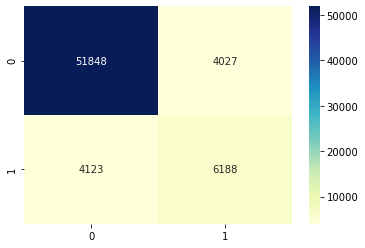

In [26]:
y_train_pred = predict(X_train, mode='best_mode')
metrics(y_train, y_train_pred)

Weighted F1 Score : 0.87649259328918
MCC Score : 0.5296909452324555


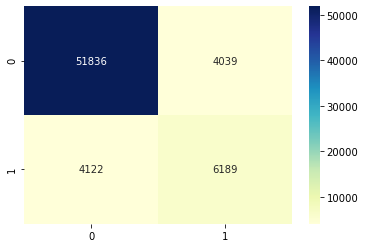

In [27]:
y_train_pred2 = predict(X_train, mode='best_mean')
metrics(y_train, y_train_pred2)

Weighted F1 Score : 0.8692859466878633
MCC Score : 0.5329133215265088


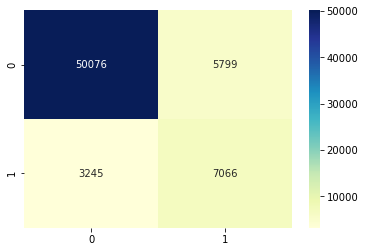

In [28]:
y_train_pred3 = predict(X_train, mode='ensemble_mode')
metrics(y_train, y_train_pred3)

Weighted F1 Score : 0.8700895751893908
MCC Score : 0.5348356539094019


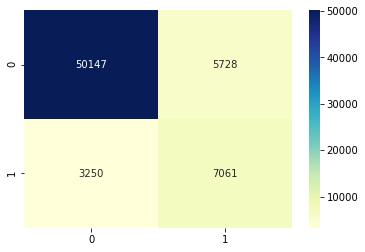

In [29]:
y_train_pred4 = predict(X_train, mode='ensemble_mean')
metrics(y_train, y_train_pred4)

[3.3364597338485296, 3.3344537511509307, 3.3324384599156054, 3.330413773349191, 3.3283796034387376, 3.3263358609287517, 3.3242824552976926, 3.322219294733919, 3.320146286111054, 3.3180633349627615]
Weighted F1 Score : 0.8712748889986816
MCC Score : 0.5358505953620997


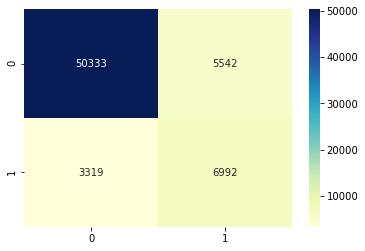

In [30]:
y_train_pred5 = predict(X_train, mode='weighted_ensemble_mean')
metrics(y_train, y_train_pred5)

# Test

In [31]:
y_test_pred = predict(X_test, mode='best_mode')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred, name='open_flag')], axis=1)
df_submission.to_csv('submission_best_mode.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [32]:
y_test_pred2 = predict(X_test, mode='best_mean')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred2, name='open_flag')], axis=1)
df_submission.to_csv('submission_best_mean.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,0


In [33]:
y_test_pred3 = predict(X_test, mode='ensemble_mode')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred3, name='open_flag')], axis=1)
df_submission.to_csv('submission_ensemble_mode.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,1


In [34]:
y_test_pred4 = predict(X_test, mode='ensemble_mean')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred4, name='open_flag')], axis=1)
df_submission.to_csv('submission_ensemble_mean.csv', index=False)

df_submission

,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,1


In [35]:
y_test_pred5 = predict(X_test, mode='weighted_ensemble_mean')

df_submission = pd.concat([pd.Series(list(range(0, len(X_test))), name='row_id', dtype=np.int32), pd.Series(y_test_pred5, name='open_flag')], axis=1)
df_submission.to_csv('submission_weighted_ensemble_mean.csv', index=False)

df_submission

[3.3364597338485296, 3.3344537511509307, 3.3324384599156054, 3.330413773349191, 3.3283796034387376, 3.3263358609287517, 3.3242824552976926, 3.322219294733919, 3.320146286111054, 3.3180633349627615]


,row_id,open_flag
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
55965,55965,0
55966,55966,0
55967,55967,0
55968,55968,1


# Visualize

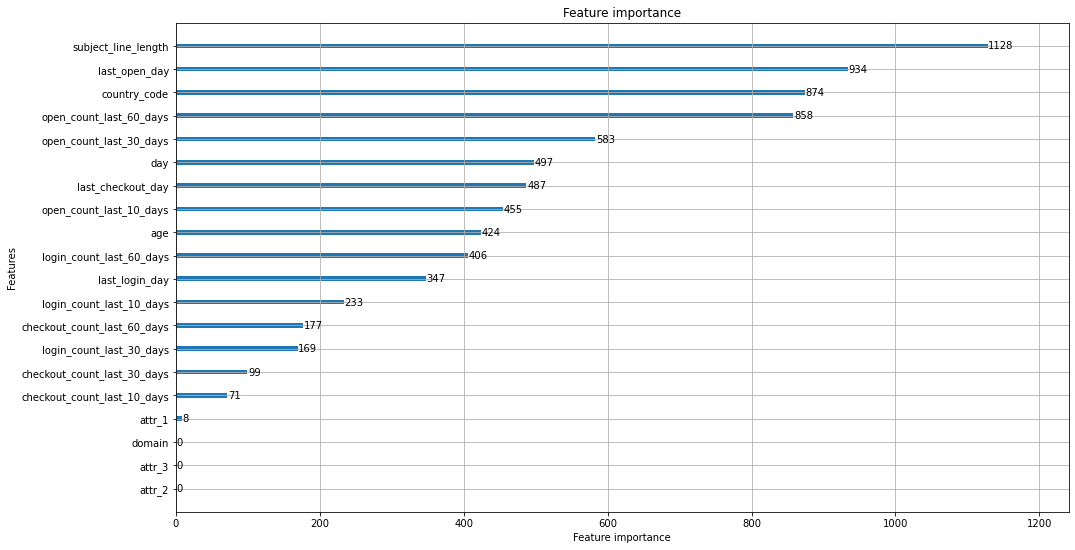

In [36]:
lgbm.plot_importance(df_model.loc[0, 'model_0'], ignore_zero=False, figsize=(16,9))

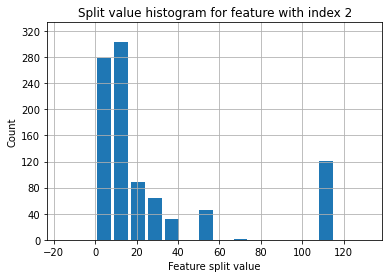

In [37]:
lgbm.plot_split_value_histogram(df_model.loc[0, 'model_0'], 2)